<a href="https://colab.research.google.com/github/SandeeeeeeeeepDey/Transformers/blob/main/Copy_of_kaggle_pll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_xla

In [ ]:
!pip install timm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

In [ ]:
!tar -xzvf "/content/drive/MyDrive/casava/archive.tar.gz" -C "/content/input/"

In [ ]:
!unzip "/content/drive/MyDrive/casava/cassava-leaf-disease-classification.zip" -d "/content/input/"

In [ ]:
# # For parallelization in TPUs
# os.environ["XLA_USE_BF16"] = "1"
# os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

In [ ]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)


In [ ]:
# general global variables
DATA_PATH = "./input"
TRAIN_PATH = "./input"
TEST_PATH = "./input"
MODEL_PATH = (
    "./input"
)

# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 15
LR = 1.85e-05
GAMMA = 0.7
N_EPOCHS = 10

In [ ]:
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
df.head()

In [ ]:
df.info


<Axes: >

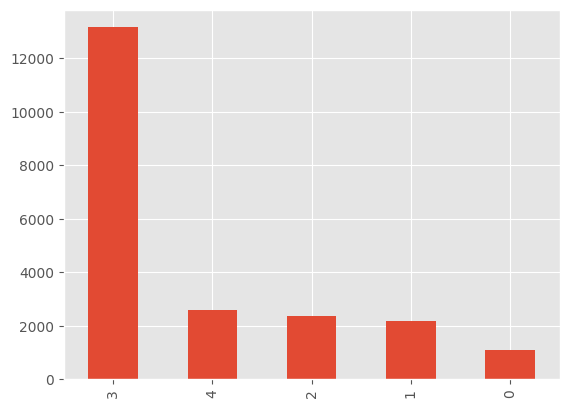

In [ ]:
df.label.value_counts().plot(kind="bar")

In [ ]:
train_df, valid_df = model_selection.train_test_split(df, test_size=0.1,randomstate=42,stratify=df.label.values)

In [ ]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [ ]:
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [ ]:
timm.list_models("vit*")

In [ ]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_small_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

            # if MODEL_PATH is not None:
            #   torch.save(self.model.state_dict(), MODEL_PATH)

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [ ]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf  # track change in validation loss

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )
            xm.save(model.state_dict(), 'best_model.pth')

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [ ]:
model = ViTBase16(n_classes=5, pretrained=False)

In [ ]:
def _run():
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True,
    )

    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=2,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=True,
        num_workers=2,
    )

    criterion = nn.CrossEntropyLoss()
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = xm.xla_device()
    model.to(device)

    lr = LR * xm.xrt_world_size()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )


    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )

In [ ]:
# Start training processes
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    a = _run()


# _run()
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=2, start_method="fork")

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


INITIALIZING TRAINING ON 1 TPU CORES
Start Time: 2024-01-25 08:35:32.006133
EPOCH 1 - TRAINING...
	BATCH 1/1283 - LOSS: 2.015625
	BATCH 21/1283 - LOSS: 1.5546875
	BATCH 41/1283 - LOSS: 1.2734375
	BATCH 61/1283 - LOSS: 0.953125
	BATCH 81/1283 - LOSS: 1.1640625
	BATCH 101/1283 - LOSS: 1.296875
